# Exercise 5: Neural Networks

## Neurons

A schematic diagram of a neuron is below:

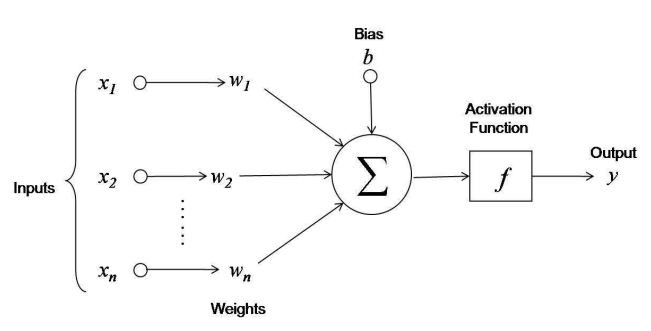

Its job is to take the weighted sum of the input variable (+ a bias) and pass it to an activation function, which restricts the range of the output.

$$
y = f(b + \sum_{i=1}^n x_i w_i)
$$

Typical activation functions are sigmoid (S-shaped) and their outputs range from -1 to 1 or from 0 to 1. Some examples can be seen by running the cell below.

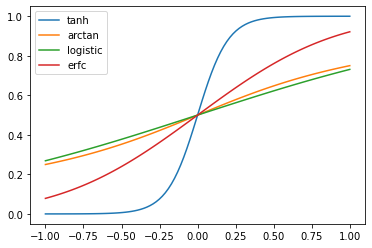

In [57]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.special import erfc
x_values = np.linspace(-1, 1, 100)
plt.plot(x_values, (np.tanh(5*x_values)+1)/2, label = "tanh");
plt.plot(x_values, 0.5+np.arctan(x_values)/np.pi, label = "arctan");
plt.plot(x_values, 1/(1+np.exp(-x_values)), label = "logistic");
plt.plot(x_values, erfc(-x_values)/2., label = "erfc");
plt.legend();

## Exercise 5.1: Classification with a Perceptron

A [Perceptron](https://en.wikipedia.org/wiki/Perceptron) is the simplest and oldest form of neural network with just a single neuron! Strictly, the activation function of a Perceptron is a Heaviside step-function, however for this exercise you should use a sigmoid function for better performance.

The dataset is a sub-set of the one used in Exercise07.

In the cell below, the data is loaded into a pandas `DataFrame` and each feature is transformed to be on a similar scale. This transformation will save a lot of time later when training the Perceptron.

In [58]:
import pandas as pd
d = pd.read_csv('training_reduced_2000.csv')
X = d.drop("signal", axis=1)
X = (X-X.mean())/X.std()
d = X.join(d["signal"])

1. Determine the 3 or 4 features with the best discriminating power and plot their distributions for signal and background.

*Hint*: You can use the same method as in Exercise 4, or just take the result from there.

LifeTime
KstestResult(statistic=0.15541765421987622, pvalue=2.0263117191781493e-10)
IP
KstestResult(statistic=0.5266387732549577, pvalue=2.5341940571380227e-120)
VertexChi2
KstestResult(statistic=0.28847325421606196, pvalue=4.0010106055305677e-35)
pt
KstestResult(statistic=0.13212958675864642, pvalue=1.1984142864854045e-07)
DOCAone
KstestResult(statistic=0.13302593366820967, pvalue=9.559861583840585e-08)
DOCAtwo
KstestResult(statistic=0.15017307123838908, pvalue=9.351330319812166e-10)
DOCAthree
KstestResult(statistic=0.1500872507896011, pvalue=9.583735294641241e-10)
isolationa
KstestResult(statistic=0.24495381058685295, pvalue=2.35229181520558e-25)
isolationb
KstestResult(statistic=0.1589935062527084, pvalue=6.937377959923752e-11)
isolationc
KstestResult(statistic=0.1291428232384823, pvalue=2.5201761096072607e-07)
p0_pt
KstestResult(statistic=0.10219626183077267, pvalue=9.484458201850091e-05)
p1_pt
KstestResult(statistic=0.12539427079636078, pvalue=6.249988770990594e-07)
p2_pt
KstestRe

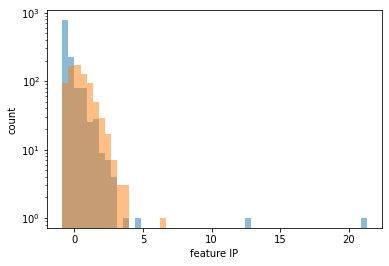

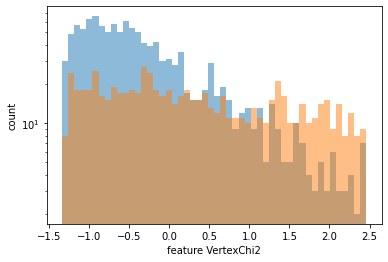

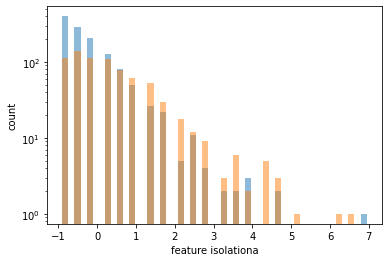

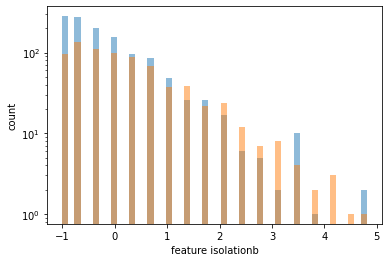

In [59]:
from scipy.stats import ks_2samp
#help(ks_2samp)
keys = d.keys()
for key in keys:
    print(key)
    print(ks_2samp(d[key][d["signal"] == 0], d[key][d["signal"] == 1]))

bestFeatures = ["IP","VertexChi2","isolationa","isolationb"]

import matplotlib.pyplot as plt

for feature in bestFeatures:
    _,bins , _= plt.hist(d[feature][d["signal"] == 1], alpha = 0.5, bins = 50)
    plt.hist(d[feature][d["signal"] == 0], alpha = 0.5, bins = bins)
    # plt.hist(d["p1_IP"], alpha = 0.5)
    plt.yscale("log")
    #plt.xlim((0,1))
    plt.ylabel("count")
    plt.xlabel(f"feature {feature}")
    plt.show()


# VertexChi2, IP, isolationa, isolationb

2. Implement a Perceptron with a sigmoid activation function.

This can be broken down into several parts:

### Output

As stated above, the output should be of the form:

$$
y = f(b + \sum_{i=1}^n x_i w_i)
$$

where the bias $b$ is also a parameter to be trained (effectively the zeroth weight $w_0$ multiplied by $x_0 = 1$).

You can choose whichever sigmoid function you like. Since the `"signal"` label in the data is either 0 or 1, make sure that the activation function produces a number $0 \leq y \leq 1$.

### Training

Training a Perceptron involves looping through the training data and updating the weights by a correction factor.

For each point in the data:
- Calculate the output $y$.
- Update each of the weights by adding a correction factor: $w_i(t+1) = w_i(t) + r (d - y) x_i$, where $t$ tracks our iteration through the data, $r$ is a tunable learning rate, and $d$ is the label on the datapoint ("signal" = 0 or 1).

The above procedure can be repeated several times until the weights converge. The speed of convergence depends on the learning rate, but too large a learning rate can lead to poor classifier performance. We recommend starting with $r=0.01$.

**NB:** $y$ must be re-calculated after each time the weights are updated.

**NB:** don't forget to update the bias while updating the weights. $b(t+1) = b(t) + r (d - y)$.

In [120]:
def y(weights, x,tanscale):
    """
    weights : numpy array weights + bias at index 0 -> length n + 1
    featrues : 2D numpy array with features (nfeat,n)
    """
    xnew = np.matmul(x , weights[1:]) + weights[0]
    return (np.tanh(tanscale*xnew)+1)/2

def updateWeights(weights, x, tanscale, learningrate, signal):
    rdy = learningrate*(signal - y(weights, x, tanscale))
    # print(np.shape(x))
    # print(y(weights, x, tanscale), signal, rdy)
    x = np.c_[np.ones(np.shape(x)[0]), x]
    # print(np.shape(rdy), np.shape(x), x)
    newweights = np.add(weights , np.matmul(rdy , x))
    return newweights

def trainPer(initWeights, data, tanscale, learningrate, signal, conv, maxIt):
    tmpweights = initWeights
    for i in range(maxIt):
        print(i)
        batchweights = tmpweights
        for k in range(len(data)):
            tmpweights = updateWeights(tmpweights,data.iloc[k:k+1],tanscale, learningrate,signal.iloc[k:k+1])
        if np.linalg.norm(batchweights - tmpweights)/np.linalg.norm(batchweights + tmpweights) < conv:
            return tmpweights
    return tmpweights

# print(d[bestFeatures])
# print(y([1,2,0,0,0],d[bestFeatures].iloc[2], 3))

initWeights = [1,1,1,1,1]
tanscale = 3
learningrate = 0.01
conv = 0.01
maxIt = 100

print(trainPer(initWeights, d[bestFeatures],tanscale, learningrate,d["signal"],conv, maxIt  ))


0
1
[ 0.0958214  -0.2202957  -0.12018027 -0.07798848 -0.05497297]


3. Split the data into training and testing samples and train your Perceptron.

*Hint:* you can use the function `train_test_split` from `sklearn.model_selection`

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(d.drop("signal", axis=1), d["signal"], test_size = 0.5)


perceptron = trainPer(initWeights, X_train[bestFeatures],tanscale, learningrate,y_train,conv, maxIt  )

0
1
2


4. Plot the response of the Perceptron on the signal and background events in the testing sample.

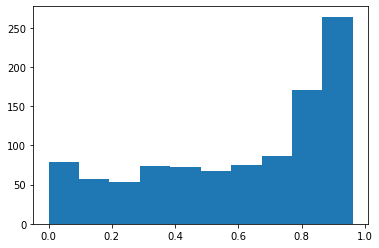

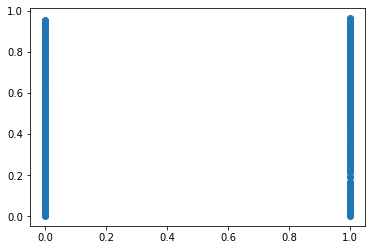

In [123]:
plt.hist(y(perceptron, X_test[bestFeatures], tanscale))
plt.show()
plt.scatter(np.array(y_test),y(perceptron, X_test[bestFeatures], tanscale))
plt.show()

5. Plot and compare ROC curves for the Perceprton output and the feature with the best discriminating power. If the training went well, the Perceptron should show better performance.

*Hint:* you can use the function `roc_curve` from `sklearn.metrics`

*Hint:* to get a good comparison, you may have to multiply either the feature or the Perceptron output by $-1$.

Text(0, 0.5, 'efficiency')

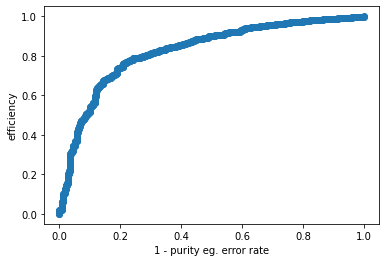

In [124]:
from sklearn.metrics import roc_curve

roc = roc_curve(y_test,y(perceptron,X_test[bestFeatures], tanscale),pos_label=1, drop_intermediate=False)
plt.scatter(roc[0],roc[1])
plt.xlabel("1 - purity eg. error rate")
plt.ylabel("efficiency")

## Exercise 5.2: Multi-layer Perceptron with Backpropagation

Here you will construct a feed-forward neural network with a hidden layer, also known as a multi-layer Perceptron (MLP).

Below is a diagram of a feed-forward network with three inputs, two hidden layers and two output nodes. For binary classification, you just need one output node.

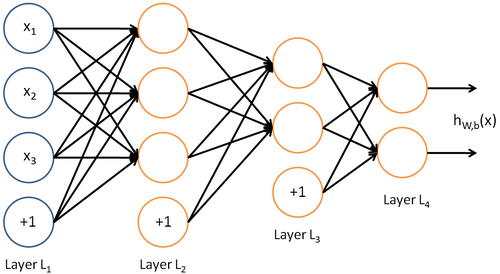

The network is trained using **backpropagation**.

Backpropagation occurs in two passes across the layers in the network. One forwards and one backwards.

In the forward pass, the output of each layer is calculated. Then in the backward pass, the error on each layer is calculated.

### Layer output

For each neuron $k$ in a layer $\ell$ (of $L$ layers), its output is

$$
y^\ell_k = f(z_k^\ell),
$$

where $f$ is the activation function and $z_k^\ell$ is the weighted sum $$b^\ell_k + \sum_{i=1}^n y^{\ell-1}_i w^\ell_{k,i},$$ where $b^\ell_k$ is a bias (equivalently a zeroth weight $w^\ell_{k,0}$), $y^{\ell-1}$ are the inputs to the neuron, and $w^\ell_{k,i}$ are the weights associated with each input. In the first layer of neurons, $y^{\ell-1} = y^{0}_i$ are the input variables. In subsequent layers, they are the outputs of the neurons in the previous layer.

Since the output of each layer depends on the previous layer, it should therefore be obvious why the output is calculated in the forward pass.

## Gradient descent

In order to update the weights and train the network, we can use a gradient descent procedure to minimise the cost function.

We will be using the quadratic cost function $C = \frac{1}{2}(d-y^L)^2$ where $d$ is the label on the datapoint (the target value) and $y^L$ is the output of the network. Its derivative is simply $$\frac{\partial C}{\partial y^L} = (y^L-d).$$

Note that this choice of cost function makes this problem essentially least-squares regression.

### Layer error

The error on the output layer is $$\delta^L \equiv \frac{\partial C}{\partial y^L}f^\prime(z^L) = (y^L - d)f^\prime(z^L),$$ where $f^\prime$ is the derivative of the activation function $\frac{df}{dz}$.

The error on each neuron $k$ in the $\ell$th layer ($\ell<L$) is a function of the error and weights of the $(\ell+1)$th layer:
$$
\delta_k^\ell \equiv \left(\sum_j w^{\ell+1}_{j,k} \delta_j^{\ell+1} \right) \cdot f^\prime(z^\ell),
$$
where the index $j$ runs over all the nodes in the $(\ell+1)$th layer.

For the case of a single hidden layer $H$ and one output neuron in the last layer $L$, this is just:

$$
\delta^H_k = w^{L}_{k} \delta^{L} \cdot f^\prime(b_k + \sum_{i} y^0_i w^H_{k,i}).
$$

Since the errors in each layer depend on the layer following it, it should also now be obvious why these must be calculated in the backwards pass.

### Adjusting the weights

The final ingredient needed to update the weights is the gradient of the cost function with respect to any weight (or bias) in the network.

$$
\frac{\partial C}{\partial w^\ell_{k,i}} = y_i^{\ell-1} \delta^\ell_k
$$

Each weight can then be adjusted by evaluating the gradients on a training sample:
$$
w^\ell_{k,i}(t+1) = w^\ell_{k,i}(t) - r \sum_x y_i^{\ell-1} \delta^\ell_k,
$$
where $t$ tracks the step in the learning process (*aka* the epoch), the index $x$ denotes each point in the training sample, and $r$ is the learning rate.

1. Implement a backpropagation training algorithm for a multi-layer Perceptron with a single hidden layer

In [133]:
import numpy as np

def leaky_ReLU(x):
  data = [max(0.05*value,value) for value in x]
  return np.array(data, dtype=float)

def leaky_ReLUderiv(x):
  data = []
  for val in x:
    if val > 0:
      data.append(1)
    else:
      data.append(0.05)
  return np.array(data, dtype=float)

def y(weights, x):
    """
    weights : numpy array weights + bias at index 0 -> length n + 1
    featrues : 2D numpy array with features (nfeat,n)
    """
    xnew = np.add(np.array(np.matmul(np.array(weights)[:,1:],np.transpose(np.array(x)))) , np.array(weights)[:,0])
    return np.transpose(leaky_ReLU(xnew)), xnew

def ylast(weights, x):
  """
  weights : numpy array weights + bias at index 0 -> length n + 1
  featrues : 2D numpy array with features (nfeat,n)
  """
  xnew = np.add(np.array(np.matmul(np.array(weights)[:,1:],np.transpose(np.array(x)))) , np.array(weights)[:,0])
  return np.transpose((np.tanh(1*xnew)+1)/2), xnew

def deltaL(ykL, d, zL):
  return (ykL - d)*((1-np.tanh(zL)**2)/2)

def deltahidden(deltalplus1, zl, w): #should return thing with dim m
  # print(np.shape(deltalplus1), np.shape(zl), np.shape(w), np.shape(np.delete(w,1,axis = -1)))
  return np.multiply(np.matmul(np.matrix(deltalplus1), np.matrix(np.delete(w,0,axis = -1))),leaky_ReLUderiv(zl)) #deltaplus (1,m) w (m,n) f' (n,1)

def deltatimesy(delta, y, learningrate): #shapes (m,1) (n,1)
  # print(np.shape(delta), np.shape(y))
  return np.c_[np.transpose(delta),np.matmul(np.transpose(np.matrix(delta)), np.matrix(y))]* (-1)*learningrate

# print(deltatimesy([[1,2,34]],[[1,2,3,4]],1))

def backpropStep(data,learningrate, weights,signal):
  ys = [*data]
  zs = []
  for w in weights[:-1]:
    # print(w, ys, zs)
    # print(ys[-1])
    yi , zi = y(w,ys[-1])
    ys.append( yi)
    zs.append(zi)

  yi , zi = ylast(weights[-1],ys[-1])
  ys.append( yi)
  zs.append(zi)
  
  # print(ys, zs)

  delta = deltaL(ys[-1],signal, zs[-1])
  wtmp = ws[-1]
  ws[-1] = np.add(ws[-1] , deltatimesy(delta, ys[-2],learningrate))
  delta = deltahidden(delta,zs[-(0+1)],wtmp)
  #print(ws[-1], deltatimesy(delta, ys[-3],learningrate))
  ws[-2] = np.add(ws[-2] , deltatimesy(delta, ys[-3],learningrate))

  # print(ys[-1] - signal)
  #print(signal)

  return ws , ys[-1], ys[-1] - signal


def trainBackprob(initWeights, data, learningrate, signal, conv, maxIt):
  tmpweights = initWeights
  for i in range(maxIt):
      #print(i)
      batchweights = tmpweights
      for k in range(len(data)):
          tmpweights = backpropStep(np.array(data.iloc[k:k+1]),learningrate, tmpweights,np.array(signal.iloc[k:k+1]))[0]
      #if np.linalg.norm(np.add(batchweights, -1*tmpweights))/np.linalg.norm(np.add(batchweights, tmpweights)) < conv:
      #    return tmpweights
  score = []
  loss = []
  for k in range(len(data)):
    score.append(backpropStep(np.array(data.iloc[k:k+1]),learningrate, tmpweights,np.array(signal.iloc[k:k+1]))[1])
    loss.append(backpropStep(np.array(data.iloc[k:k+1]),learningrate, tmpweights,np.array(signal.iloc[k:k+1]))[2])
  return tmpweights, score, loss

# ws = np.random.randint(0,5,(3,4,5)) # n layer / output / input (1 bias)
ws = [[[1,2,3,4,5],[1,1,1,1,1],[1,0.5,0.5,0.7,0.8]],[[0.01,0.01,0.01,0.01]]]
yk = d[bestFeatures].iloc[2:3]

weights , score, loss = trainBackprob(ws, X_train[bestFeatures],0.01,y_train,0.1,30 )



2. Train your neural network on the same training sample as the Perceptron. Choose an appropriate set of features and hyper-parameters to try to balance training time vs performance.

In [136]:
print(np.transpose(score))
print(weights)

[[4.71630729e-02 8.30613192e-01 1.22563695e-04 7.68477882e-01
  1.46263478e-01 2.19847595e-01 7.40768830e-01 8.08458170e-01
  8.60535474e-01 6.56604601e-01 9.21665860e-01 1.88088931e-01
  4.08710504e-01 5.42999105e-03 8.28875407e-01 4.12607868e-01
  7.08720169e-01 8.14781029e-01 1.78937022e-01 8.72230504e-01
  4.93546667e-01 1.84184684e-03 8.49574958e-01 8.60659255e-01
  7.73795547e-01 8.51233898e-01 8.07948228e-01 1.52141698e-02
  8.18766765e-01 8.59940583e-01 3.90427014e-02 3.67223695e-03
  8.62690498e-01 3.77313603e-04 5.80754093e-02 3.13141740e-03
  1.81498597e-04 8.41702890e-01 8.43770330e-01 8.39494184e-01
  8.14276193e-01 9.95897965e-04 0.00000000e+00 8.56403621e-01
  8.64967246e-01 8.49804513e-01 1.82718387e-03 2.29907449e-03
  8.64667404e-01 2.92294823e-05 8.18227745e-01 1.65191215e-02
  8.61717603e-01 8.64066386e-01 7.56220907e-01 2.09134492e-03
  6.84132852e-01 6.29941672e-01 8.59030826e-01 7.53438154e-01
  1.77350796e-03 1.11631825e-02 5.24615266e-01 5.43170918e-01
  1.3474

3. Plot the response of the Perceptron on the signal and background events in the testing sample.

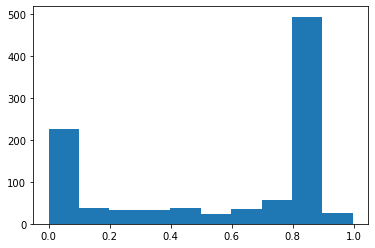

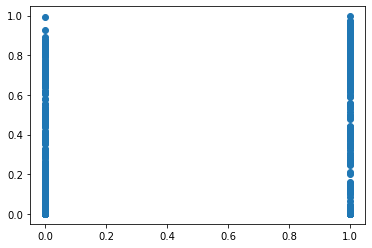

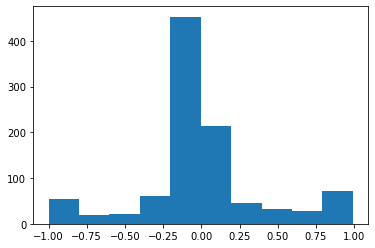

In [134]:
plt.hist(np.transpose(score)[0])
plt.show()
plt.scatter(np.array(y_train), np.transpose(score)[0])
plt.show()
plt.hist(np.transpose(loss)[0])
plt.show()

4. Plot and compare ROC curves for the MLP and Perceprton outputs

Text(0, 0.5, 'efficiency')

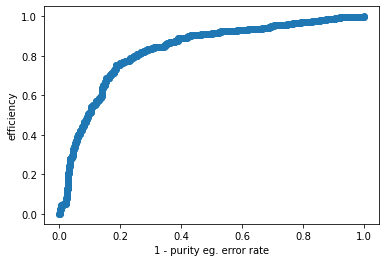

In [135]:
from sklearn.metrics import roc_curve

roc = roc_curve(y_train,np.transpose(score)[0],pos_label=1, drop_intermediate=False)
plt.scatter(roc[0],roc[1])
plt.xlabel("1 - purity eg. error rate")
plt.ylabel("efficiency")